# Module 2 Final Project
Emily J. Cain

## Hypothesis 1
* H0 - Discount amount does not have a statistically significant effect on the quantity of the product ordered.
* H1 - Discount amount has a statistically significant effect on the quantity of the product ordered.

### Further Questions
* At what level(s) of discount?

## Hypothesis 2
* H0 -
* H2 -

## Hypothesis 3
* H0 -
* H3 -

## Hypothesis 4
* H0 -
* H4 - 

## Ideas
* Does the database show how long a customer has been with the company? Does customer loyalty have an effect on orders? Actionable - target specific customers
* Certain products and their sales - is there a product more popular in a certain regions where we could use targeted advertising? 

## Establish connection to the database

In [76]:
import sqlite3
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
conn = sqlite3.connect('Northwind_small.sqlite')
c = conn.cursor()

## Grab table names

In [5]:
c.execute("SELECT name FROM sqlite_master WHERE type = 'table';").fetchall()

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',)]

## Create dataframes of each table for initial inspection

In [6]:
employee_df = pd.read_sql_query('SELECT * FROM Employee;', conn)
employee_df.head()

,Id,LastName,FirstName,Title,TitleOfCourtesy,BirthDate,HireDate,Address,City,Region,PostalCode,Country,HomePhone,Extension,Photo,Notes,ReportsTo,PhotoPath
0,1,Davolio,Nancy,Sales Representative,Ms.,1980-12-08,2024-05-01,507 - 20th Ave. E. Apt. 2A,Seattle,North America,98122,USA,(206) 555-9857,5467,None,Education includes a BA in psychology from Col...,2.0,http://accweb/emmployees/davolio.bmp
1,2,Fuller,Andrew,"Vice President, Sales",Dr.,1984-02-19,2024-08-14,908 W. Capital Way,Tacoma,North America,98401,USA,(206) 555-9482,3457,None,Andrew received his BTS commercial in 1974 and...,NaN,http://accweb/emmployees/fuller.bmp
2,3,Leverling,Janet,Sales Representative,Ms.,1995-08-30,2024-04-01,722 Moss Bay Blvd.,Kirkland,North America,98033,USA,(206) 555-3412,3355,None,Janet has a BS degree in chemistry from Boston...,2.0,http://accweb/emmployees/leverling.bmp
3,4,Peacock,Margaret,Sales Representative,Mrs.,1969-09-19,2025-05-03,4110 Old Redmond Rd.,Redmond,North America,98052,USA,(206) 555-8122,5176,None,Margaret holds a BA in English literature from...,2.0,http://accweb/emmployees/peacock.bmp
4,5,Buchanan,Steven,Sales Manager,Mr.,1987-03-04,2025-10-17,14 Garrett Hill,London,British Isles,SW1 8JR,UK,(71) 555-4848,3453,None,Steven Buchanan graduated from St. Andrews Uni...,2.0,http://accweb/emmployees/buchanan.bmp


In [7]:
category_df = pd.read_sql_query('SELECT * FROM Category;', conn)
category_df.head()

,Id,CategoryName,Description
0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,2,Condiments,"Sweet and savory sauces, relishes, spreads, an..."
2,3,Confections,"Desserts, candies, and sweet breads"
3,4,Dairy Products,Cheeses
4,5,Grains/Cereals,"Breads, crackers, pasta, and cereal"


In [8]:
customer_df = pd.read_sql_query('SELECT * FROM Customer;', conn)
customer_df.head()

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67


In [9]:
shipper_df = pd.read_sql_query('SELECT * FROM Shipper;', conn)
shipper_df.head()

,Id,CompanyName,Phone
0,1,Speedy Express,(503) 555-9831
1,2,United Package,(503) 555-3199
2,3,Federal Shipping,(503) 555-9931


In [10]:
supplier_df = pd.read_sql_query('SELECT * FROM Supplier;', conn)
supplier_df.head()

,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,HomePage
0,1,Exotic Liquids,Charlotte Cooper,Purchasing Manager,49 Gilbert St.,London,British Isles,EC1 4SD,UK,(171) 555-2222,None,None
1,2,New Orleans Cajun Delights,Shelley Burke,Order Administrator,P.O. Box 78934,New Orleans,North America,70117,USA,(100) 555-4822,None,#CAJUN.HTM#
2,3,Grandma Kelly's Homestead,Regina Murphy,Sales Representative,707 Oxford Rd.,Ann Arbor,North America,48104,USA,(313) 555-5735,(313) 555-3349,None
3,4,Tokyo Traders,Yoshi Nagase,Marketing Manager,9-8 Sekimai Musashino-shi,Tokyo,Eastern Asia,100,Japan,(03) 3555-5011,None,None
4,5,Cooperativa de Quesos 'Las Cabras',Antonio del Valle Saavedra,Export Administrator,Calle del Rosal 4,Oviedo,Southern Europe,33007,Spain,(98) 598 76 54,None,None


Use square brackets when querying ```[Order]``` due to being a reserved keyword 

In [11]:
order_df = pd.read_sql_query('SELECT * FROM [Order];', conn)
order_df.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [12]:
product_df = pd.read_sql_query('SELECT * FROM Product;', conn)
product_df.head()

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.00,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,0
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.00,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1


In [13]:
order_detail_df = pd.read_sql_query('SELECT * FROM OrderDetail;', conn)
order_detail_df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [14]:
customer_customer_demo_df = pd.read_sql_query('SELECT * FROM CustomerCustomerDemo;', conn)
customer_customer_demo_df.head()

,Id,CustomerTypeId


In [15]:
customer_demographic_df = pd.read_sql_query('SELECT * FROM CustomerDemographic', conn)
customer_demographic_df.head()

,Id,CustomerDesc


In [16]:
region_df = pd.read_sql_query('SELECT * FROM Region;', conn)
region_df.head()

,Id,RegionDescription
0,1,Eastern
1,2,Western
2,3,Northern
3,4,Southern


In [17]:
territory_df = pd.read_sql_query('SELECT * FROM Territory;', conn)
territory_df.head()

,Id,TerritoryDescription,RegionId
0,01581,Westboro,1
1,01730,Bedford,1
2,01833,Georgetow,1
3,02116,Boston,1
4,02139,Cambridge,1


In [18]:
employee_territory_df = pd.read_sql_query('SELECT * FROM EmployeeTerritory;', conn)
employee_territory_df.head()

,Id,EmployeeId,TerritoryId
0,1/06897,1,06897
1,1/19713,1,19713
2,2/01581,2,01581
3,2/01730,2,01730
4,2/01833,2,01833


## Hypothesis 1
* H0 - Discount amount does not have a statistically significant effect on the quantity of the product ordered.
* H1 - Discount amount has a statistically significant effect on the quantity of the product ordered.

### Further Questions
* At what level(s) of discount?

In [19]:
order_detail_df.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167
std,241.378032,22.159019,29.827418,19.022047,0.083450
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


In [20]:
quantity_discount_df = pd.read_sql_query('SELECT Quantity, Discount FROM OrderDetail', conn)
quantity_discount_df.head()

,Quantity,Discount
0,12,0.0
1,10,0.0
2,5,0.0
3,9,0.0
4,40,0.0


In [21]:
# X = discount
# Y = quantity

In [56]:
X = quantity_discount_df.iloc[:,1].values
Y = quantity_discount_df.iloc[:,0].values

In [59]:
X.shape

(2155,)

### Visualizing Data

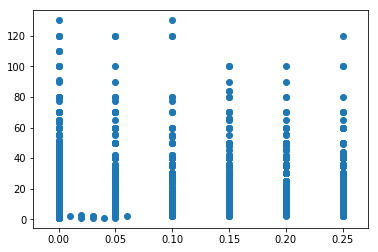

In [53]:
plt.scatter(X, Y);

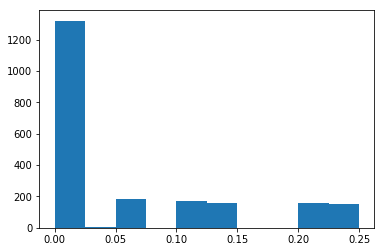

In [47]:
plt.hist(X);

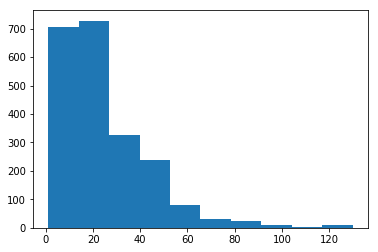

In [48]:
plt.hist(Y);

### Initial Model with Holdout Validation

In [62]:
# assigning a random_state guarantees that the split results will be the same each time I run this cell
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [69]:
X_train = X_train.reshape(-1,1)
X_train.shape

(1724, 1)

In [72]:
X_test = X_test.reshape(-1,1)
X_test.shape

(431, 1)

In [73]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [74]:
clf = GaussianNB()
clf.fit(X_train_scaled, Y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [75]:
Y_pred = clf.predict(X_test_scaled)

In [77]:
accuracy_score(Y_test, Y_pred)

0.002320185614849188

In [78]:
# WELL THAT'S PRETTY TERRIBLE 